In [28]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, GlobalAveragePooling1D, Conv2D, ConvLSTM2D, ConvLSTM1D, Input, Flatten, Reshape, TextVectorization, concatenate
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
#from tensorflow.keras import ops
import keras
import numpy as np

tf.config.run_functions_eagerly(True)


In [29]:
"""Vars"""
sample_headlines = ["Hoo Hoo", "HOO", "WHOSE TOES", "HOO", "Hoo hoo hoo"]
sample_prices = [34.3, 40.4, 90, 30, 0.5]
sample_gains = [0] + [(sample_prices[i+1]-sample_prices[i])/sample_prices[i] for i in range(0, len(sample_prices)-1)]
var_duration = 2
sample_vars = [0 for i in range(var_duration)] + [np.std(sample_prices[i:i+var_duration]) for i in range(0, len(sample_prices)-var_duration)]
print("sample gains: ", sample_gains)
print("smaple vars: ", sample_vars)
#print("zipped: ", np.array(zip(np.array(sample_gains), np.array(sample_vars))))
zipped_labels = [[sample_gains[i], sample_vars[i]] for i in range(len(sample_gains))]
print("zipped: ", zipped_labels)

vocab_size = 50
max_len = 30
embeddings_dim = 1#5

num_past_prices = 30


sample gains:  [0, 0.1778425655976677, 1.2277227722772277, -0.6666666666666666, -0.9833333333333333]
smaple vars:  [0, 0, 3.0500000000000007, 24.8, 30.0]
zipped:  [[0, 0], [0.1778425655976677, 0], [1.2277227722772277, 3.0500000000000007], [-0.6666666666666666, 24.8], [-0.9833333333333333, 30.0]]


In [30]:
"""Encoder Methods"""
def get_one_hot_encoded_batch(vocab_size, strings):
    return [one_hot(string, vocab_size) for string in strings]

def pad_input(max_len, one_hot_encoded_strings):
    return pad_sequences(one_hot_encoded_strings, maxlen=max_len)



In [31]:
"""Encoder Architecture"""
input = Input(shape=(max_len))
embeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(input) # look at TextVecotirzation
#flatten_1 = Flatten()(embeddings_1) 
#reshape_1 = Reshape((max_len, -1))(embeddings_1)
lstm_1 = LSTM(units=30, return_sequences=False)(embeddings_1) # Default activation tanh - VERIFY
dense_1 = Dense(units=30)(lstm_1)
dense_2 = Dense(units=1)(dense_1)
output = dense_2 # Perhaps more to come

encoder = keras.Model(inputs = input, outputs = output)
encoder.compile(optimizer="rmsprop", loss="mse")
print(encoder.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 30, 1)             50        
                                                                 
 lstm_18 (LSTM)              (None, 30)                3840      
                                                                 
 dense_14 (Dense)            (None, 30)                930       
                                                                 
 dense_15 (Dense)            (None, 1)                 31        
                                                                 
Total params: 4851 (18.95 KB)
Trainable params: 4851 (18.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [32]:
"""Encoder Architecture 2
input = Input(shape=(max_len, vocab_size))
embeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(input)
#flatten_1 = Flatten()(embeddings_1)
reshape_1 = Reshape((max_len, vocab_size))(embeddings_1)
lstm_1 = LSTM(units=30, return_sequences=False)(reshape_1) # Default activation tanh - VERIFY
dense_1 = Dense(units=30)(lstm_1)
dense_2 = Dense(units=2)(dense_1)
output = dense_2 # Perhaps more to come

encoder = keras.Model(inputs = input, outputs = output)
encoder.compile(optimizer="rmsprop", loss="mse")
print(encoder.summary())"""

'Encoder Architecture 2\ninput = Input(shape=(max_len, vocab_size))\nembeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(input)\n#flatten_1 = Flatten()(embeddings_1)\nreshape_1 = Reshape((max_len, vocab_size))(embeddings_1)\nlstm_1 = LSTM(units=30, return_sequences=False)(reshape_1) # Default activation tanh - VERIFY\ndense_1 = Dense(units=30)(lstm_1)\ndense_2 = Dense(units=2)(dense_1)\noutput = dense_2 # Perhaps more to come\n\nencoder = keras.Model(inputs = input, outputs = output)\nencoder.compile(optimizer="rmsprop", loss="mse")\nprint(encoder.summary())'

In [33]:
"""Data Processing"""
one_hots = get_one_hot_encoded_batch(vocab_size=vocab_size, strings=sample_headlines)
padded_one_hots = pad_input(max_len=max_len, one_hot_encoded_strings=one_hots)
print(padded_one_hots)
dataset = tf.data.Dataset.from_tensor_slices(sample_headlines)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0 14  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  5  5  5]]


In [34]:
"""Model Training"""
encoder.fit(x=padded_one_hots, y=np.array(zipped_labels), epochs=10)#np.array(zip(sample_gains, sample_vars)))

Epoch 1/10
1/1 [==============================] - 0s 35ms/step - loss: 152.6599
Epoch 2/10
1/1 [==============================] - 0s 31ms/step - loss: 152.1075
Epoch 3/10
1/1 [==============================] - 0s 31ms/step - loss: 151.5986
Epoch 4/10
1/1 [==============================] - 0s 29ms/step - loss: 151.0374
Epoch 5/10
1/1 [==============================] - 0s 29ms/step - loss: 150.3703
Epoch 6/10
1/1 [==============================] - 0s 31ms/step - loss: 149.5333
Epoch 7/10
1/1 [==============================] - 0s 30ms/step - loss: 148.4289
Epoch 8/10
1/1 [==============================] - 0s 29ms/step - loss: 146.8689
Epoch 9/10
1/1 [==============================] - 0s 30ms/step - loss: 144.5082
Epoch 10/10
1/1 [==============================] - 0s 29ms/step - loss: 140.7633


In [35]:
"""Encoder Architecture 3"""
input = Input(shape=(1, ), dtype=tf.string)

tv_layer = TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=max_len)
tv_layer.adapt(dataset.batch(64))

tv_layer_1 = tv_layer(input)
embeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(tv_layer_1)
#flatten_1 = Flatten()(embeddings_1)
#reshape_1 = Reshape((max_len, vocab_size))(embeddings_1)
lstm_1 = LSTM(units=30, return_sequences=False)(embeddings_1) # Default activation tanh - VERIFY
dense_1 = Dense(units=30)(lstm_1)
dense_2 = Dense(units=2)(dense_1)
output = dense_2 # Perhaps more to come

encoder = keras.Model(inputs = input, outputs = output)
encoder.compile(optimizer="rmsprop", loss="mse")
print(encoder.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_7 (Text  (None, 30)                0         
 Vectorization)                                                  
                                                                 
 embedding_9 (Embedding)     (None, 30, 1)             50        
                                                                 
 lstm_19 (LSTM)              (None, 30)                3840      
                                                                 
 dense_16 (Dense)            (None, 30)                930       
                                                                 
 dense_17 (Dense)            (None, 2)                 62        
                                                           

In [36]:
"""Model Training"""
encoder.fit(x=np.array(sample_headlines), y=np.array(zipped_labels), epochs=10)#np.array(zip(sample_gains, sample_vars)))

Epoch 1/10
1/1 [==============================] - 0s 37ms/step - loss: 152.8084
Epoch 2/10
1/1 [==============================] - 0s 31ms/step - loss: 152.3661
Epoch 3/10
1/1 [==============================] - 0s 31ms/step - loss: 152.0103
Epoch 4/10
1/1 [==============================] - 0s 31ms/step - loss: 151.6363
Epoch 5/10
1/1 [==============================] - 0s 30ms/step - loss: 151.1986
Epoch 6/10
1/1 [==============================] - 0s 31ms/step - loss: 150.6462
Epoch 7/10
1/1 [==============================] - 0s 30ms/step - loss: 149.9020
Epoch 8/10
1/1 [==============================] - 0s 31ms/step - loss: 148.8286
Epoch 9/10
1/1 [==============================] - 0s 31ms/step - loss: 147.1679
Epoch 10/10
1/1 [==============================] - 0s 30ms/step - loss: 144.4057


In [37]:
"""Encoder Architecture 4"""
input = Input(shape=(1, ), dtype=tf.string)

tv_layer = TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=max_len)
tv_layer.adapt(dataset.batch(64))

tv_layer_1 = tv_layer(input)
embeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(tv_layer_1)
#flatten_1 = Flatten()(embeddings_1)
#reshape_1 = Reshape((max_len, vocab_size))(embeddings_1)
lstm_1 = LSTM(units=30, return_sequences=False)(embeddings_1) # Default activation tanh - VERIFY
#dense_1 = Dense(units=30)(lstm_1)
output = lstm_1#dense_1


encoder = keras.Model(inputs = input, outputs = output)
encoder.compile(optimizer="rmsprop", loss="mse")
print(encoder.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_8 (Text  (None, 30)                0         
 Vectorization)                                                  
                                                                 
 embedding_10 (Embedding)    (None, 30, 1)             50        
                                                                 
 lstm_20 (LSTM)              (None, 30)                3840      
                                                                 
Total params: 3890 (15.20 KB)
Trainable params: 3890 (15.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_gains (InputLayer)    [(None, 30)]                 0         []                            
                                                                                                  
 reshape_6 (Reshape)         (None, 30, 1)                0         ['input_gains[0][0]']         
                                                                                                  
 input_headlines (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 lstm_25 (LSTM)              (None, 30, 64)               16896     ['reshape_6[0][0]']    

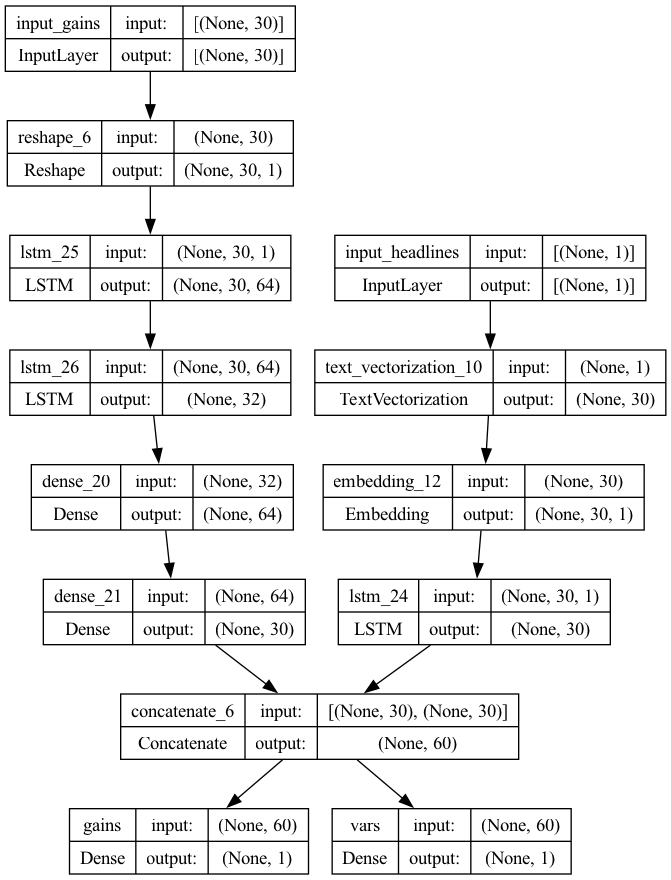

In [63]:
# Constants
max_len = 30
max_tokens = 1000

# Gather tf dataset to adapt TextVectorizer
sample_historical_headlines = ["Hoo Hoo", "HOO", "WHOSE TOES", "HOO", "Hoo hoo hoo"] # replace with array of historical data
dataset = tf.data.Dataset.from_tensor_slices(sample_historical_headlines)

"""Total arch"""
# Headline Encoder
input_headlines = Input(shape=(1, ), dtype=tf.string, name="input_headlines")

tv_layer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=max_len)
tv_layer.adapt(dataset.batch(64))

tv_layer_1 = tv_layer(input_headlines)
embeddings_1 = Embedding(input_dim=max_tokens+1, output_dim=embeddings_dim, input_length=max_len)(tv_layer_1)
lstm_1 = LSTM(units=30, return_sequences=False)(embeddings_1) # Default activation tanh
embedded_headlines = lstm_1 # More to compe perhaps

# Stock Gain Encoder
input_gains = Input(shape=(num_past_prices), name="input_gains")
inp_reshaped = Reshape((num_past_prices, 1))(input_gains)
#g_lstm_1 = ConvLSTM1D(filters=32, kernel_size=5, padding='same')(inp_reshaped) TODO
g_lstm_1 = LSTM(units=64, return_sequences=True)(inp_reshaped)
g_lstm_2 = LSTM(units=32, return_sequences=False)(g_lstm_1)

# Dense
g_dense_1 = Dense(units=64, activation='relu')(g_lstm_2)
g_dense_2 = Dense(units=30)(g_dense_1)

# Concat with headlines embeddings
concatted_gains_embeds = concatenate([embedded_headlines, g_dense_2])

# output dense layers
out_dense_1 = Dense(units = 1, name="gains")(concatted_gains_embeds)
out_dense_2 = Dense(units = 1, name="vars")(concatted_gains_embeds)

model = keras.Model(
    inputs = [input_headlines, input_gains], 
    outputs = {"gains":out_dense_1, "vars":out_dense_2}
)

model.compile(optimizer="adam", loss="mean_squared_error")
         #     loss={
         #         "gains":,
         #         "vars":
         #     })
print(model.summary())
keras.utils.plot_model(model, "sussamodel.png", show_shapes=True)

In [64]:
"""Training megamodel"""
# Make dummy data
dummy_headlines = np.array(["hoo", "HOO HOO HOO", "ahhhh", "d", "dfs"], dtype=str) # Replace with headlines (one per sequence of prices)
dummy_gains_in = np.random.rand(len(dummy_headlines), num_past_prices) # Replace with sequence of prices (eg. past 5 weeks' prices)
dummy_gains_out = np.random.rand(len(dummy_headlines), 1) # Sequence of predicted prices
dummy_vars = np.random.rand(len(dummy_headlines), 1) # Sequence of predicted vars

# Train
model.fit(
    {"input_headlines": dummy_headlines, "input_gains": dummy_gains_in},
    {"gains": dummy_gains_out, "vars": dummy_vars},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
1/1 [==============================] - 0s 116ms/step - loss: 0.6636 - gains_loss: 0.4882 - vars_loss: 0.1754
Epoch 2/2


/opt/homebrew/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 85ms/step - loss: 0.6023 - gains_loss: 0.4339 - vars_loss: 0.1685


In [65]:
"""Sample Predict"""
# Batch prediction (just using training data)
prediction_batch = model.predict([dummy_headlines, dummy_gains_in])

# Single prediction
prediction_single = model.predict([np.array(["hoo hoo HOO HOOOO WHOA WHOAAA"]), np.random.rand(1, num_past_prices)])

# Single prediction (batch of 1)

print("batch: ", prediction_batch)
print("single: ", prediction_single)

1/1 [==============================] - 0s 44ms/step
batch:  {'gains': array([[0.03402742],
       [0.03502539],
       [0.03350562],
       [0.03723126],
       [0.03434823]], dtype=float32), 'vars': array([[0.10514174],
       [0.09269454],
       [0.09278629],
       [0.09000631],
       [0.12505959]], dtype=float32)}
single:  {'gains': array([[0.03178975]], dtype=float32), 'vars': array([[0.1084228]], dtype=float32)}
